In [151]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


In [152]:
# Import Dataset
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (42, 2)


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [153]:
#Data Exploration
#Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [154]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [155]:
#Descriptive Analysis
df.shape

(42, 2)

In [156]:
#Checking the data types
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [157]:
#Unique values for every feature
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [159]:
df[df.duplicated()].shape

(0, 2)

In [160]:
df[df.duplicated()]

,Quarter,Sales


In [161]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [162]:
#Feature Engineering
#Converting the Quarters into Years
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [163]:
#Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [164]:
#Extracting the Quarters and putting in column
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [165]:
#Creating Dummy Variables for Quarters Variable
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()


,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [166]:
#Dropping all the unnecessary column
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [167]:
#Making the Date as DateTime index for the Dataframe
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [168]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [169]:
#Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


<AxesSubplot:xlabel='month', ylabel='year'>

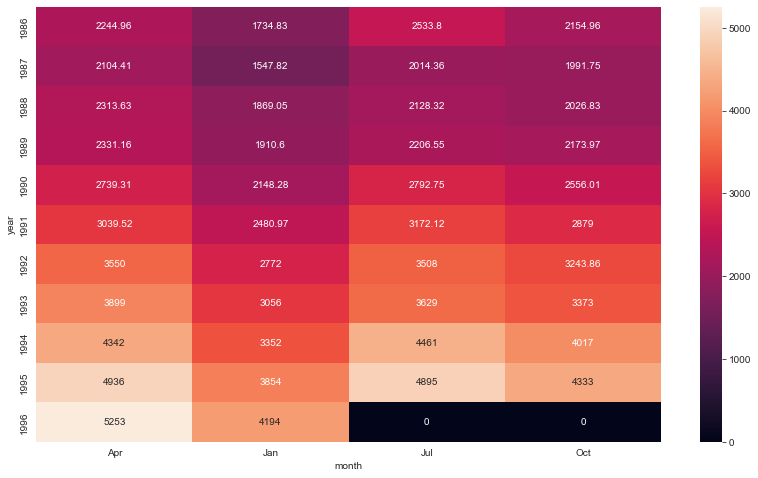

In [170]:
#Data Visualization
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

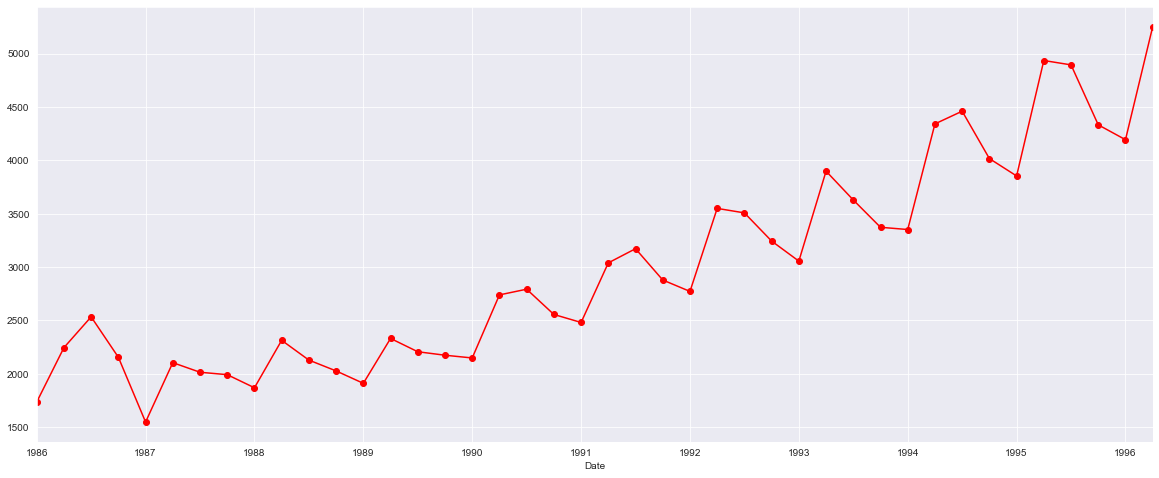

In [171]:
#Line plot
df1['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

In [173]:
#Observation:
#We can see that there is an increasing Trend. So, Trend is not constant.
#Variance is also not constant.
#Hence the time serise is not stationary.

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

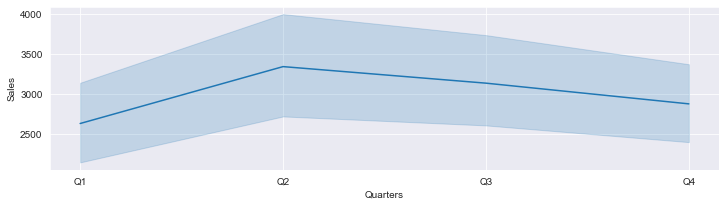

In [174]:
#Line Plot Using Quarters as Y axis and Sales as X axis
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


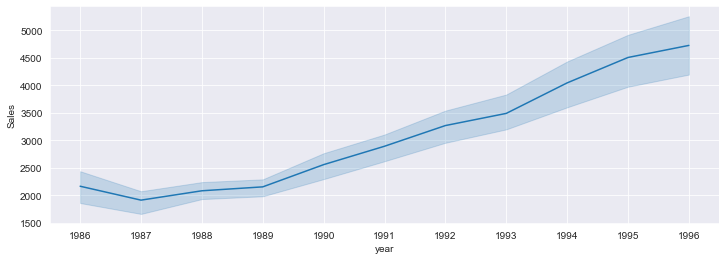

In [175]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

<AxesSubplot:xlabel='year', ylabel='Sales'>

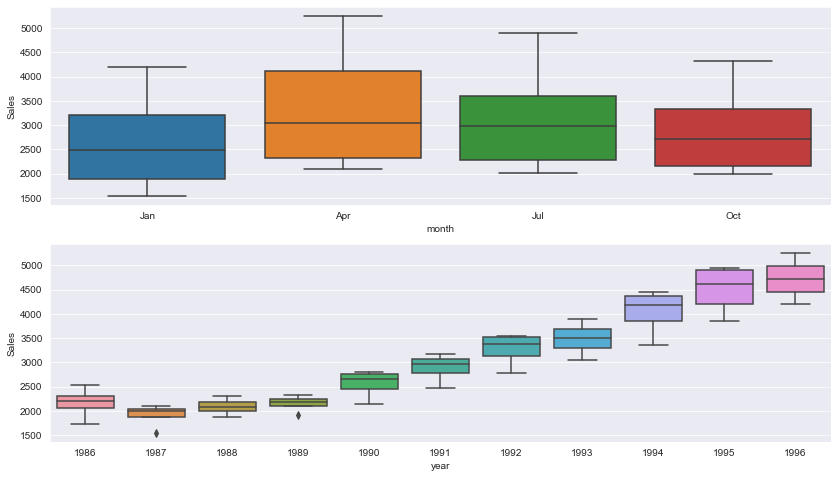

In [176]:
#Box Plot of Each Year by Quaterly Intervals
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

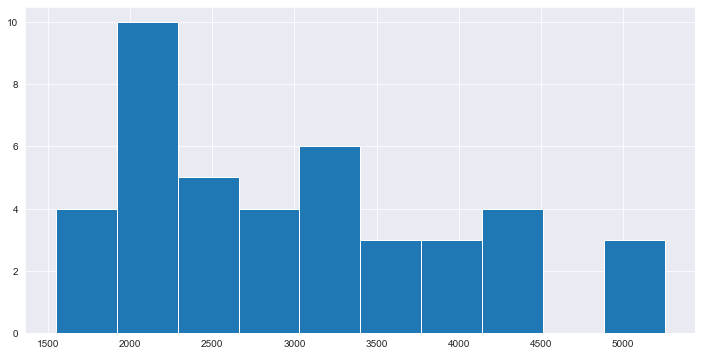

In [177]:
#Histogram and Density Plots
df.Sales.hist(figsize=(12,6))
plt.show()

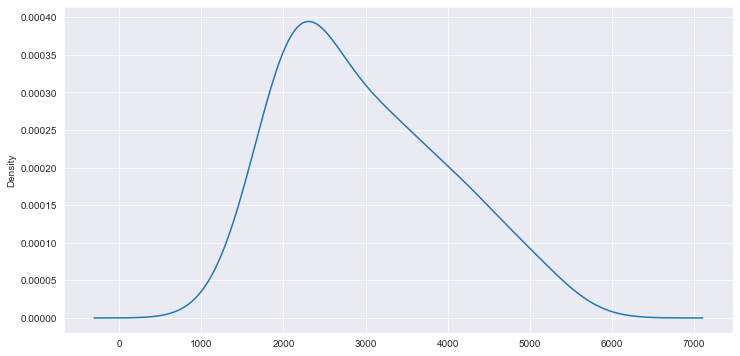

In [178]:
# create a density plot
df.Sales.plot(kind='kde', figsize=(12,6))
plt.show()

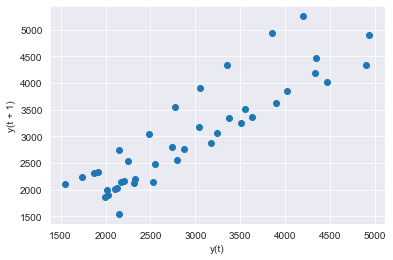

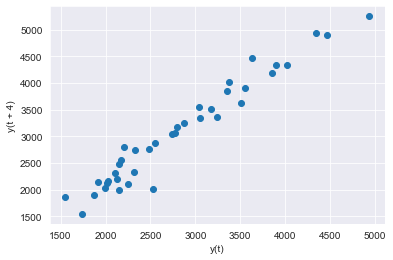

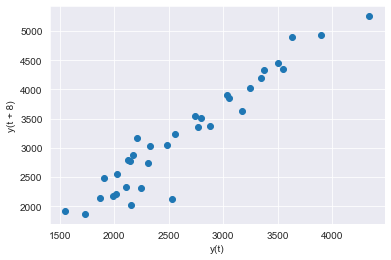

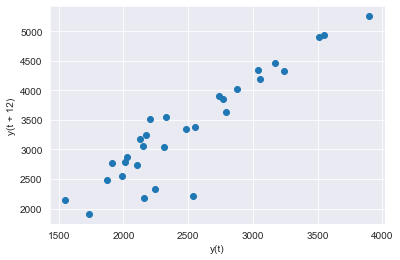

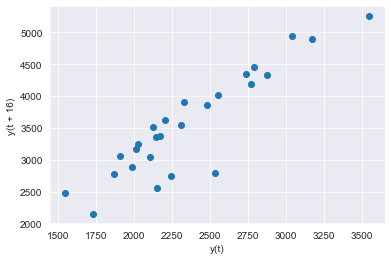

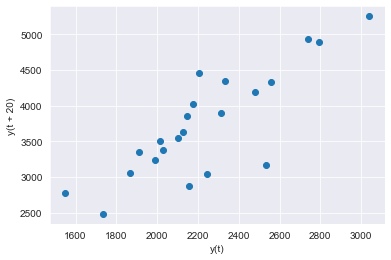

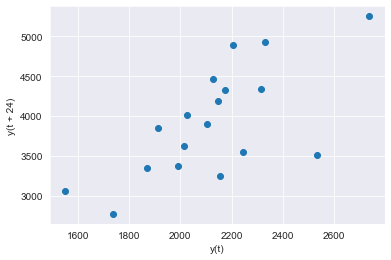

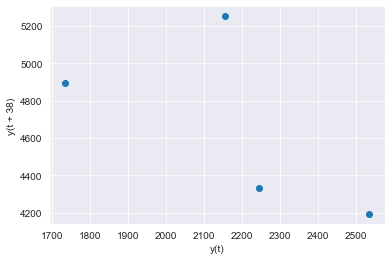

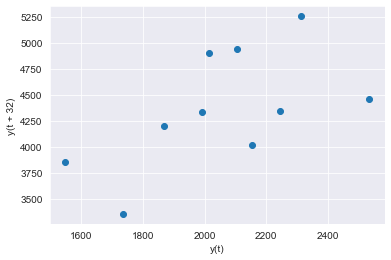

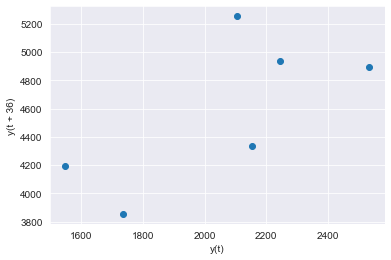

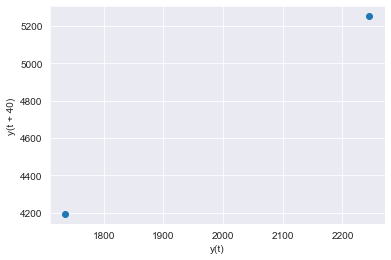

In [179]:
#Lag plot
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Sales, lag=i)
    plt.show()

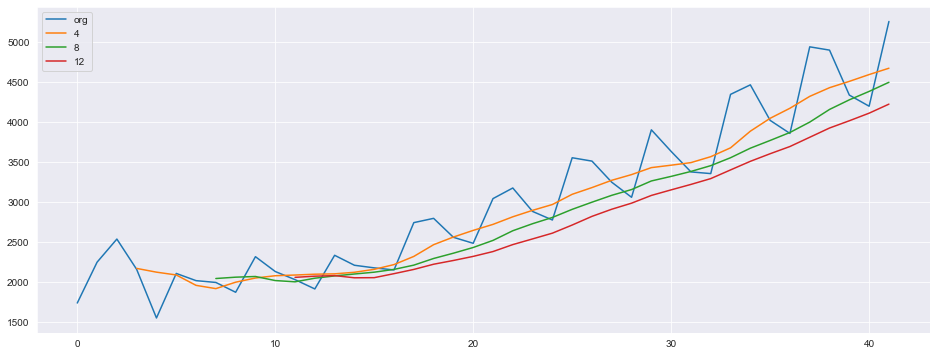

In [180]:
#Moving Average
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

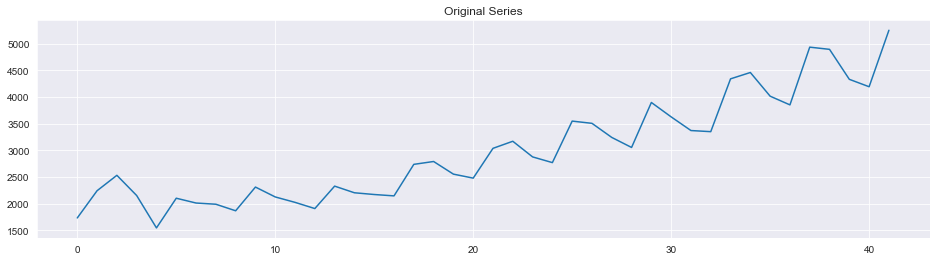

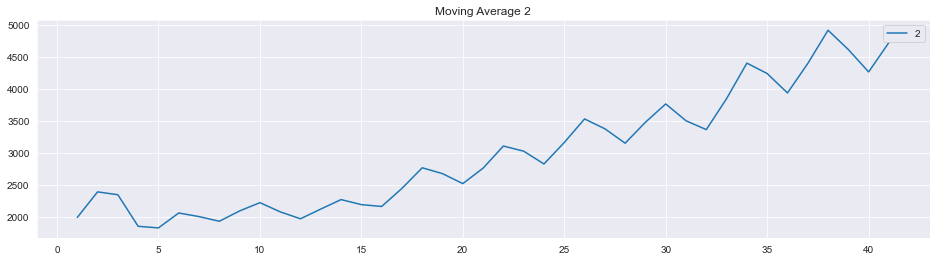

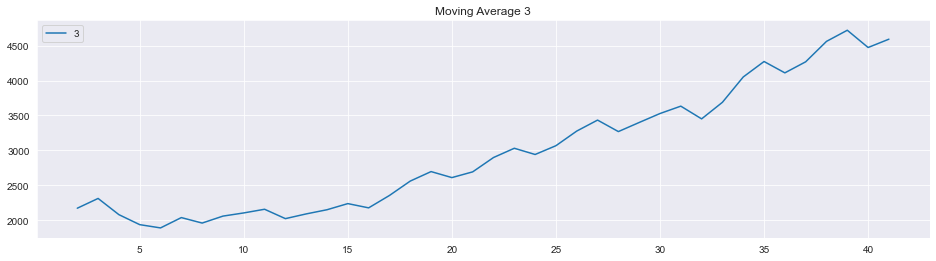

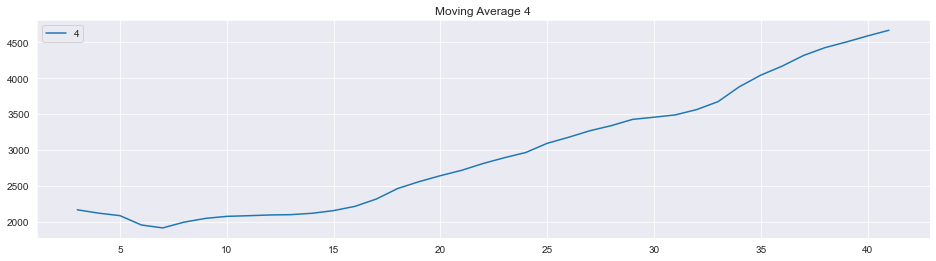

In [181]:
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

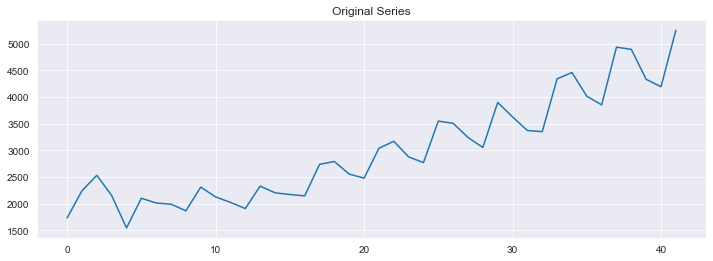

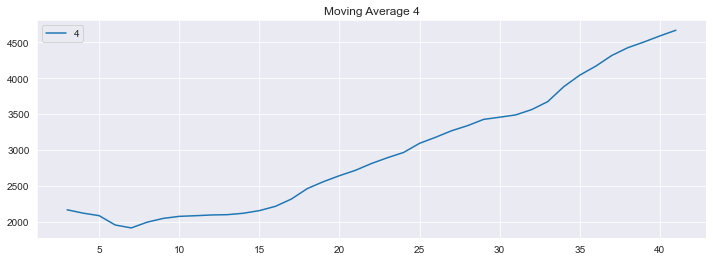

In [182]:
plt.figure(figsize=(12,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

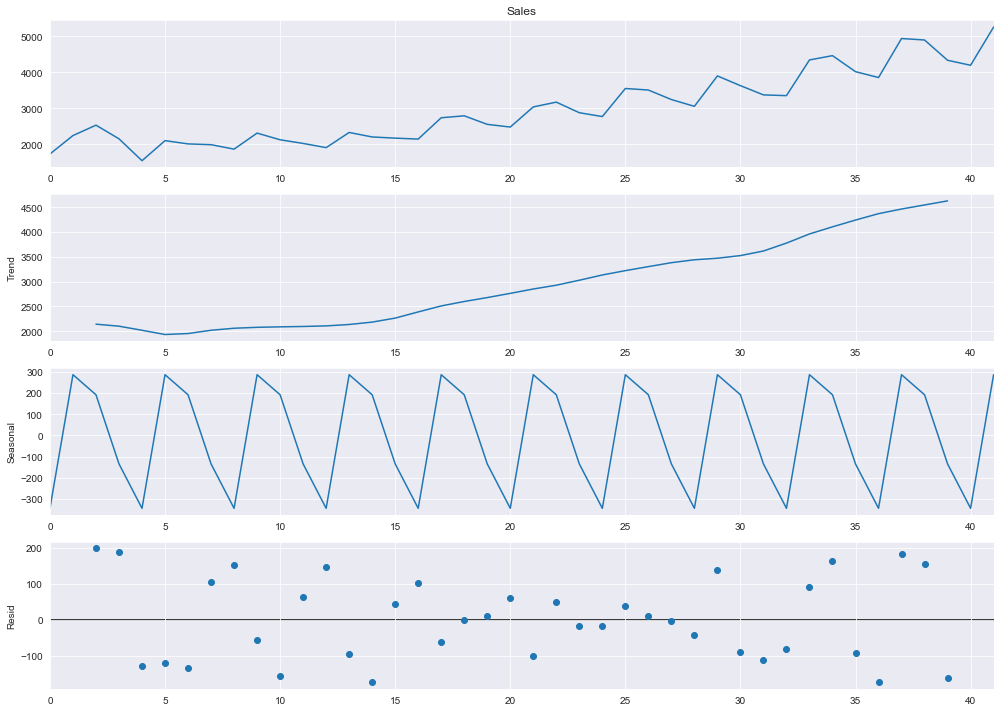

In [183]:
#Time series decomposition plot
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

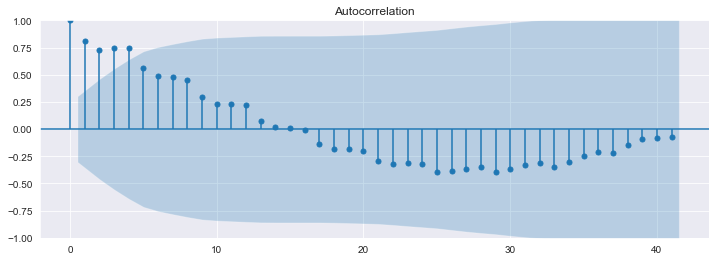

In [184]:
#ACF plots and PACF plots
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    plt.show()

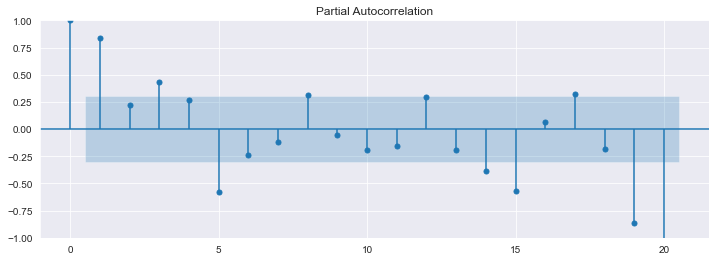

In [185]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

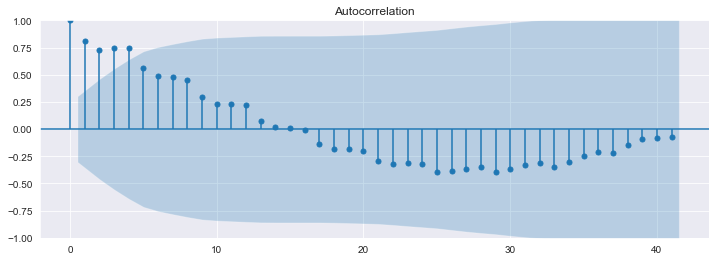

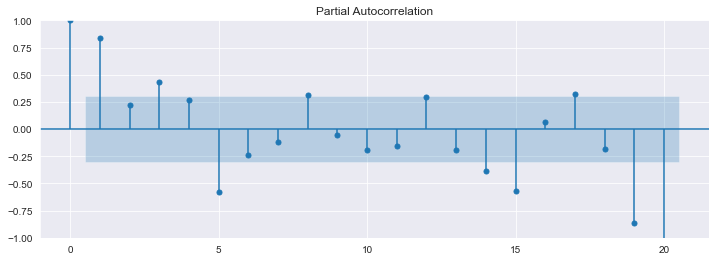

In [186]:
#To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version 
#of itself.
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

In [187]:
#Sampling
#Linear interpolation
#upsampling with respect to month
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


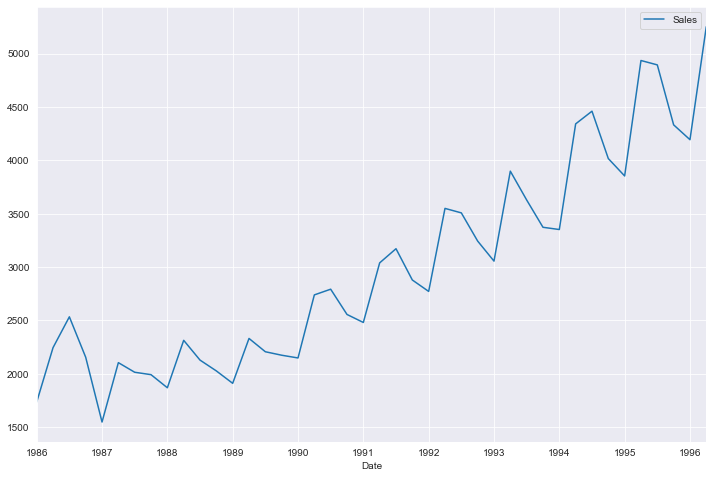

In [188]:
interpolated_month = upsampled_month.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(12,8))
plt.show()

In [189]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [190]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]

,Sales,date,year,month,week,quarter,day_of_week
0,1734.827000,1986-01-31,1986,1,5,1,Friday
1,1904.871666,1986-02-28,1986,2,9,1,Friday


In [191]:
# data 
df_1986 = visual[visual['year']==1986][['month','Sales']]
df_1986 = df_1986.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1986'})
df_1987 = visual[visual['year']==1987][['month','Sales']]
df_1987 = df_1987.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1987'})
df_1988 = visual[visual['year']==1988][['month','Sales']]
df_1988 = df_1988.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1988'})
df_1989 = visual[visual['year']==1989][['month','Sales']]
df_1989 = df_1989.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1989'})
df_1990 = visual[visual['year']==1990][['month','Sales']]
df_1990 = df_1990.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1990'})
df_1991 = visual[visual['year']==1991][['month','Sales']]
df_1991 = df_1991.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1991'})
df_1992 = visual[visual['year']==1992][['month','Sales']]
df_1992 = df_1992.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1992'})
df_1993 = visual[visual['year']==1993][['month','Sales']]
df_1993 = df_1993.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1993'})
df_1994 = visual[visual['year']==1994][['month','Sales']]
df_1994 = df_1994.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1994'})
df_1995 = visual[visual['year']==1995][['month','Sales']]
df_1995 = df_1995.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1995'})

df_year = df_1986.merge(df_1987,on='month').merge(df_1988,on='month').merge(df_1989,on='month').merge(df_1990,on='month')\
.merge(df_1991,on='month').merge(df_1992,on='month').merge(df_1993,on='month').merge(df_1994,on='month').merge(df_1995,on='month')

# top levels
top_labels = ['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)'
          ,'rgb(197, 237, 221)','rgb(236, 249, 244)']

# X axis value 
df_year = df_year[['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1986['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1986['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

In [192]:
#Observation:
Highest sales are made in June, July, May, April month and then decreases in January.
Sales are increasing gradually from 1986 to 1995.
Note: We don't have enough data for 1996

SyntaxError: invalid syntax (928229244.py, line 2)

In [193]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"Sales" : "mean"}).reset_index()
df_m_sa['Sales'] = round(df_m_sa['Sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Sales'].astype(str) 

df_w_sa = visual.groupby('week').agg({"Sales" : "mean"}).reset_index() 
df_q_sa = visual.groupby('quarter').agg({"Sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [194]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"Sales" : "mean"}).reset_index()
df_dw_sa.Sales = round(df_dw_sa.Sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

In [195]:
#Observation:
As we saw in the above chart there is an upward trend in sales over the time. Although there are ups and downs at every point in time, generally we can observe that the trend increases. Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too. Let’s take a closer look by observing some year’s data:
Highest sales are made on Tuesday.
April month has the highest sales.

SyntaxError: invalid syntax (2260651714.py, line 2)

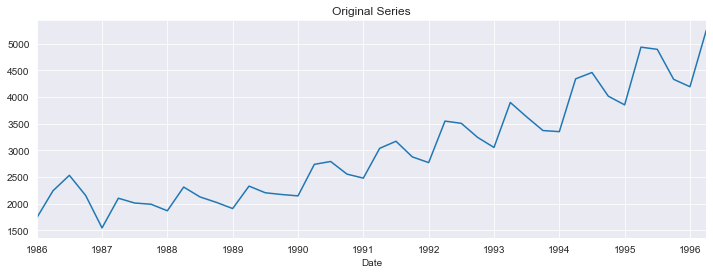

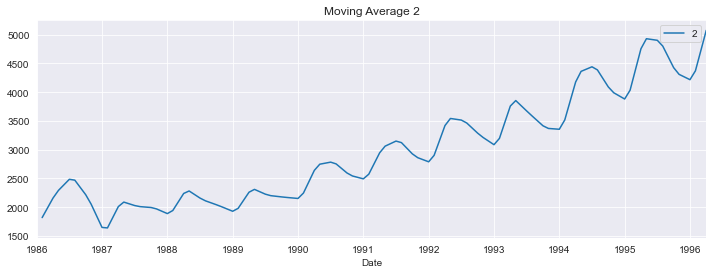

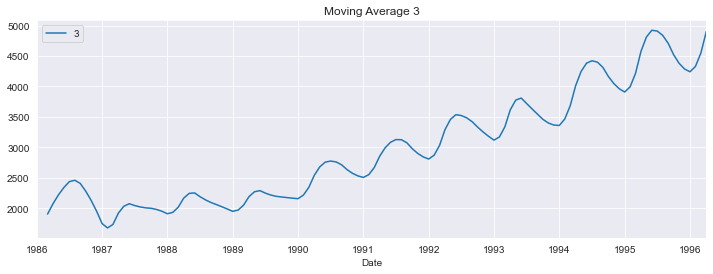

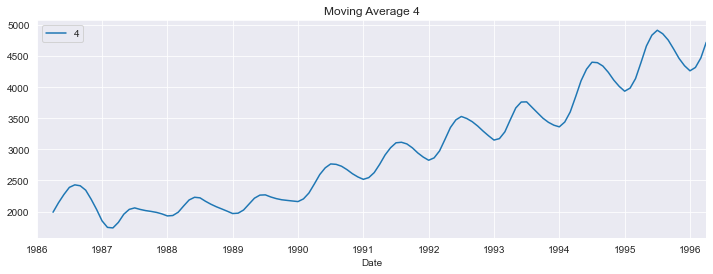

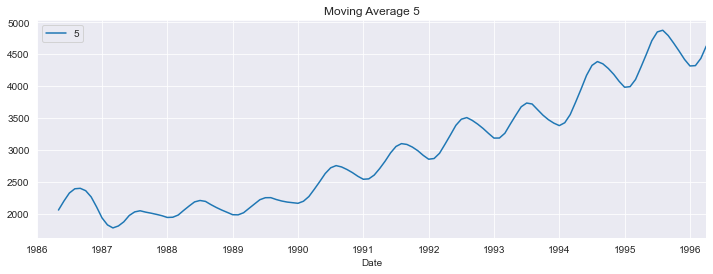

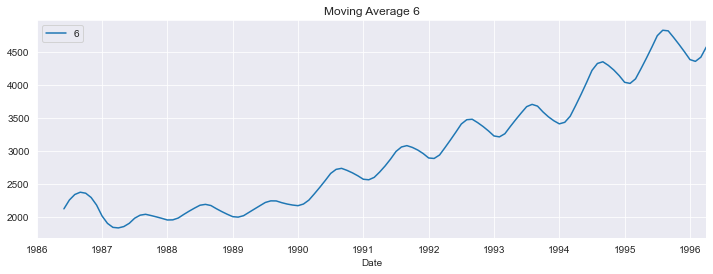

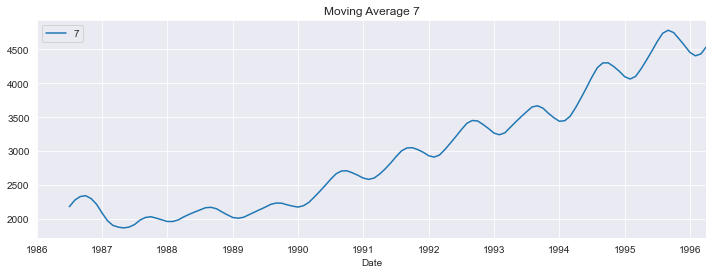

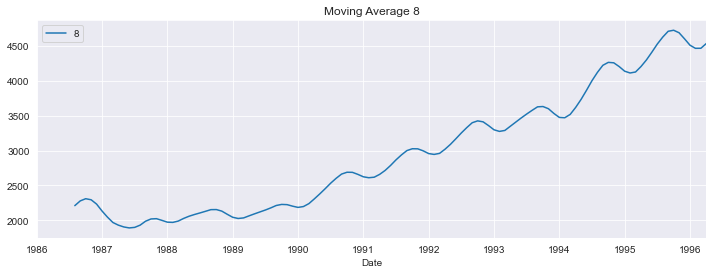

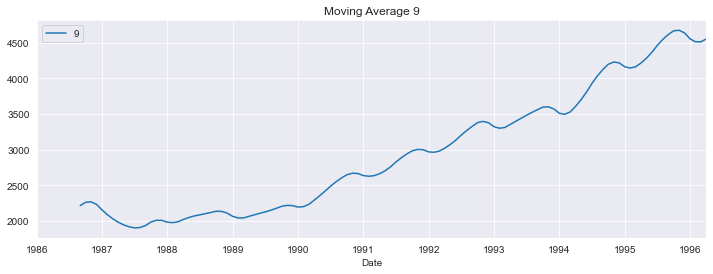

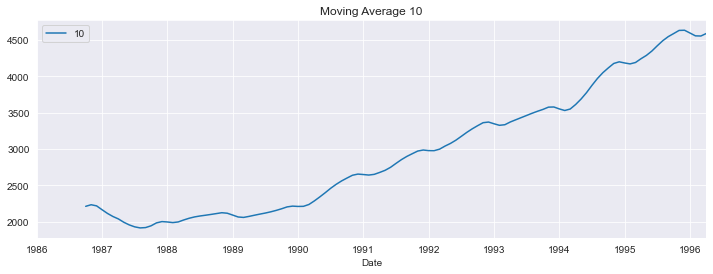

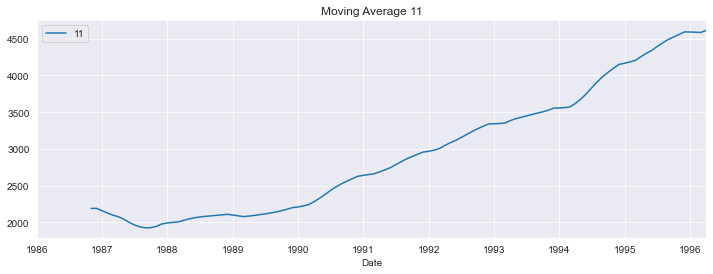

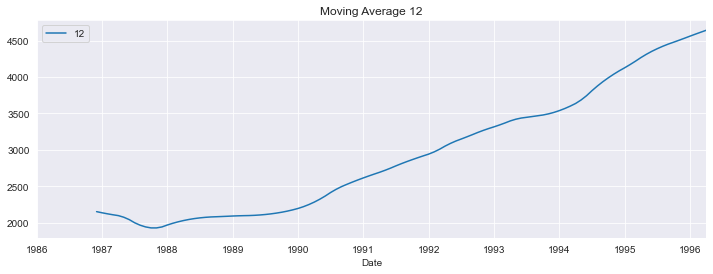

In [196]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

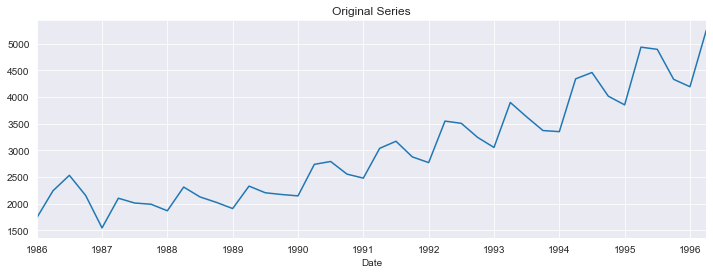

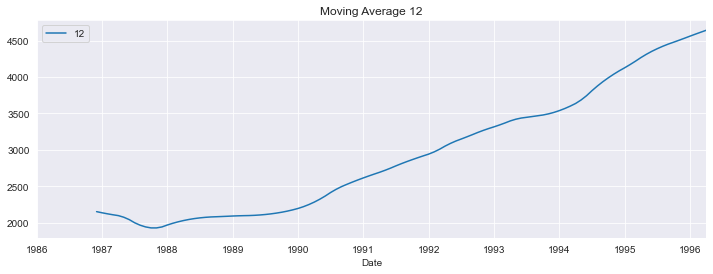

In [197]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

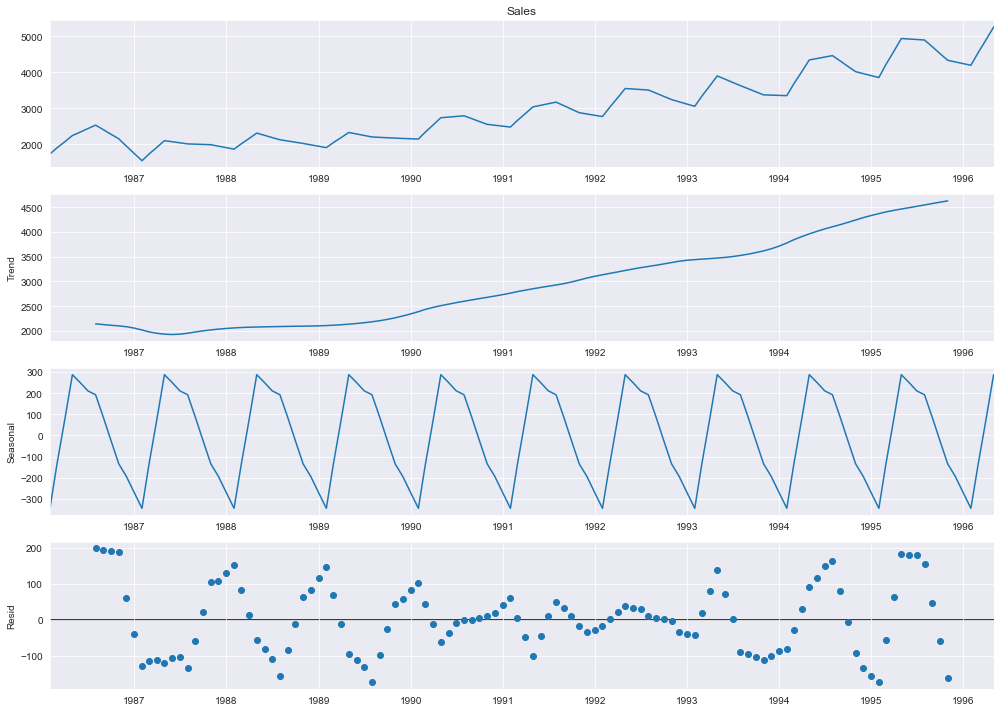

In [198]:
#Additive Seasonal Decomposition
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

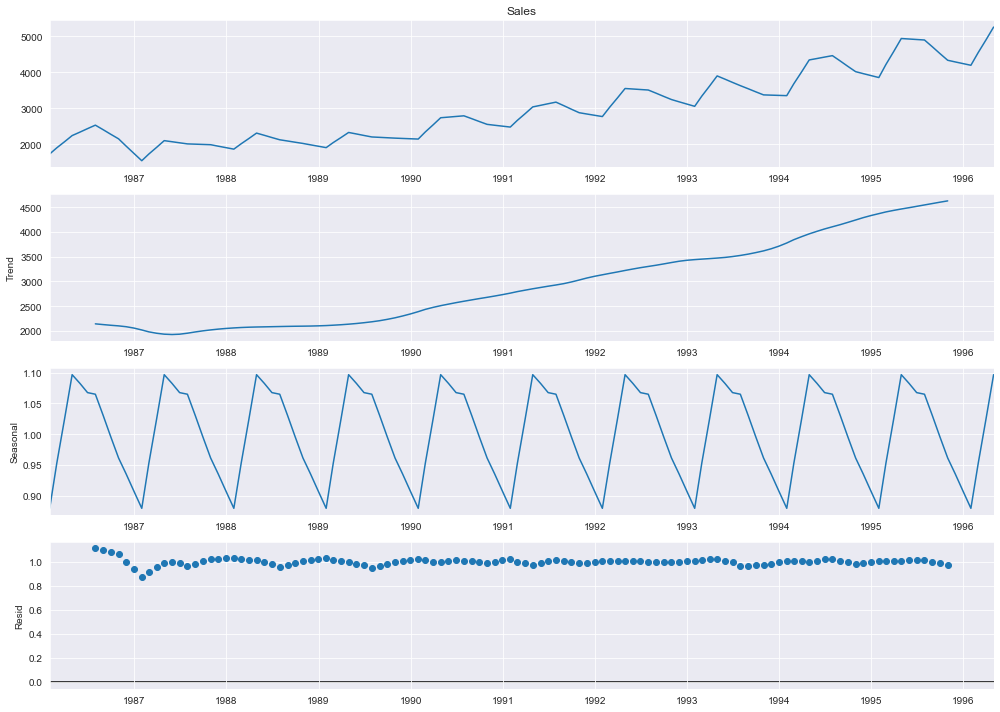

In [199]:
#Multiplicative Seasonal Decomposition
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [200]:
#Splitting Train and Test Data
#Leaving Test Data with 2 Years of Time Series
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


<AxesSubplot:xlabel='Date'>

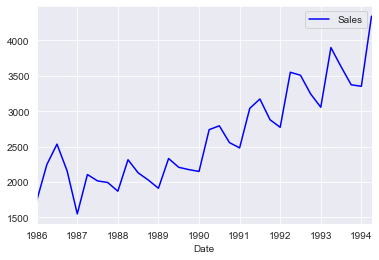

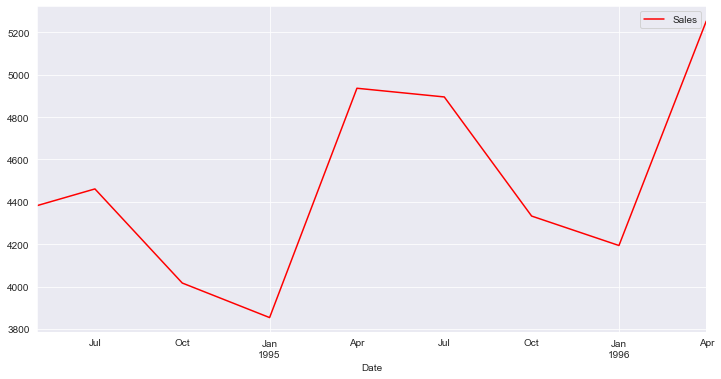

In [201]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

In [202]:
#Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [203]:
#Exponential Methods
#Simple Exponential Method
#Using Forecast Attribute
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.619719427225402 
 Train Root Mean Squared Error = 129.37951453141417 
 Test Root Mean Squared Error = 381.95422355078995


In [204]:
#Using Predict Attribute
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.619719427225402 
 Train Root Mean Squared Error = 129.37951453141417 
 Test Root Mean Squared Error = 381.95422355078995


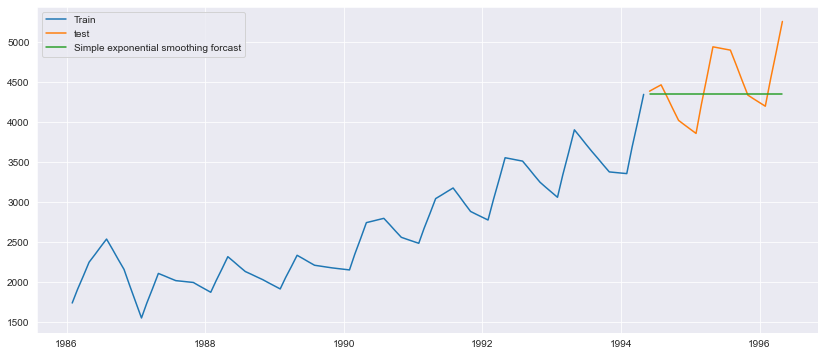

In [205]:
#Difference between Predict and Forecast attribute ( the same as in "Biscuit" and "Biscoot")
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [206]:
#Observation
No seasonality captures.
Most recent observation gets higher weightages than the older ones for forecasting.

SyntaxError: invalid syntax (1153165930.py, line 2)

In [207]:
#Holt method (Double Exponential)
#Captures both Level and Trend .
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.7001615463704 
 Train Root Mean Squared Error = 108.58347720512378 
 Test Root Mean Squared Error = 4560.457728458048


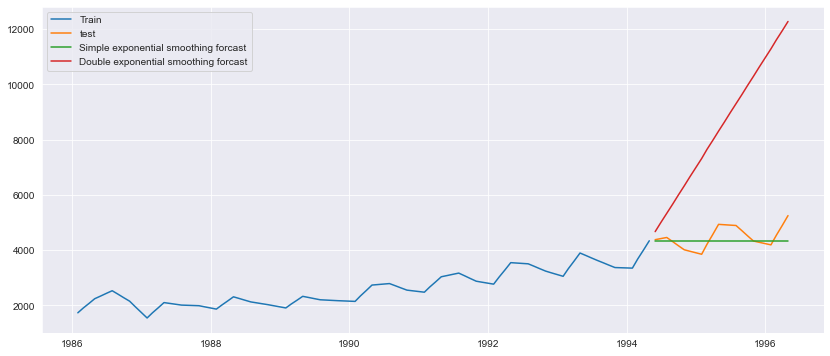

In [208]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [209]:
#Observation
We can see that we are able to capture the trend of the data but the level is on another level.
We were not able to capture the seasonality.

SyntaxError: invalid syntax (434463159.py, line 2)

In [210]:
#Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
#Captures Level, Trend and Seasonality.
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 34.23944156457067 
 Train Root Mean Squared Error = 44.17572264662261 
 Test Root Mean Squared Error = 1758.7055544098644


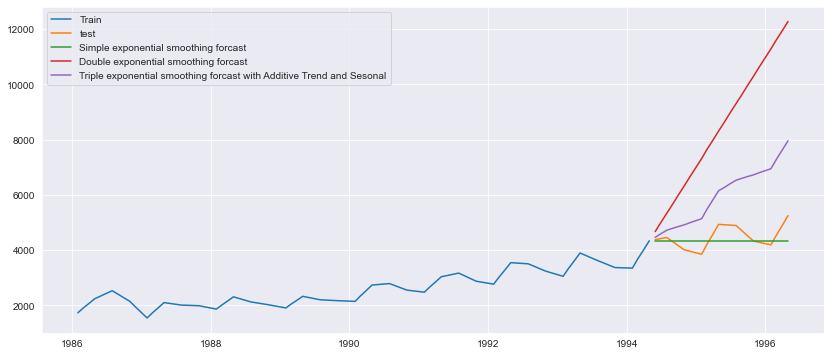

In [211]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

In [212]:
#Observation
It captures the trend, which we can see that the forecasted values are higher level than the test level.
It also captures the seasonality.
The peak of the forecasted value is higher than the actual.

SyntaxError: invalid syntax (2740932738.py, line 2)

In [213]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 1.483298493452904 
 Train Root Mean Squared Error = 50.22454696270186 
 Test Root Mean Squared Error = 78.3845682517769


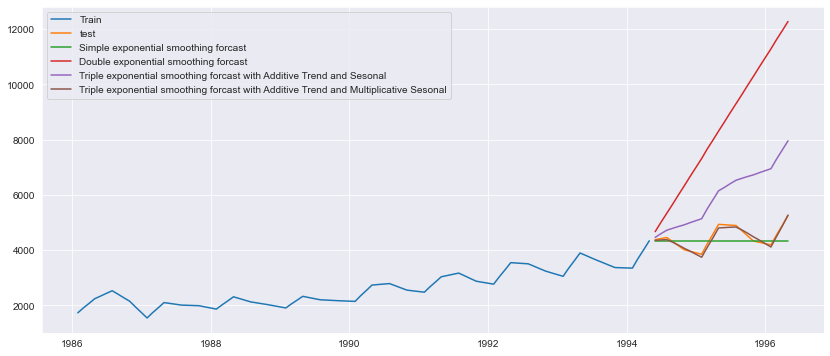

In [214]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

In [215]:
#Observation
We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

SyntaxError: invalid syntax (2217944109.py, line 2)

In [216]:
#Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 5.157134449259166 
 Train Root Mean Squared Error = 166.60624759961158 
 Test Root Mean Squared Error = 269.5054193081448


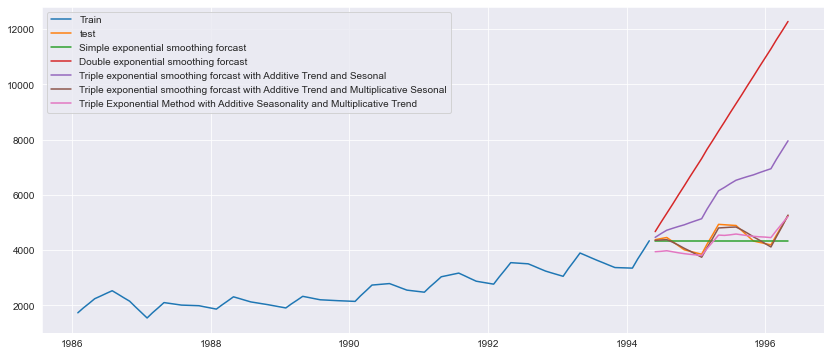

In [217]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

In [218]:
#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 2.6327808147458014 
 Train Root Mean Squared Error = 42.561957415060434 
 Test Root Mean Squared Error = 168.8434861791096


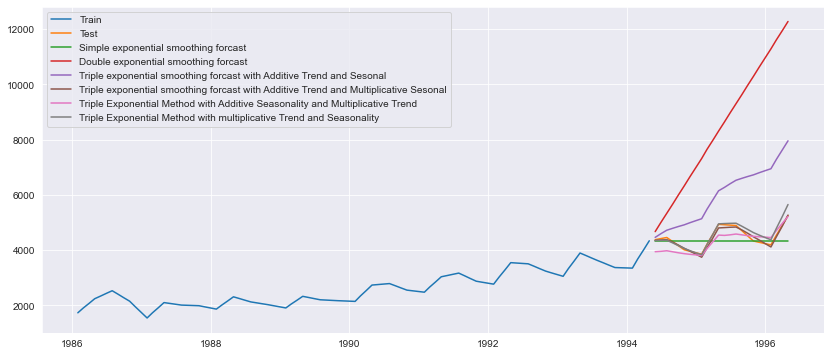

In [219]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [220]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_mul_ad,50.224547,1.483298,78.384568
1,Triple_Exp_mul,42.561957,2.632781,168.843486
2,Triple_Exp_ad_mul,166.606248,5.157134,269.505419
3,Simple_Exp,129.379515,6.619719,381.954224
4,Triple_Exp_ad,44.175723,34.239442,1758.705554
5,Double_Exp,108.583477,89.700162,4560.457728


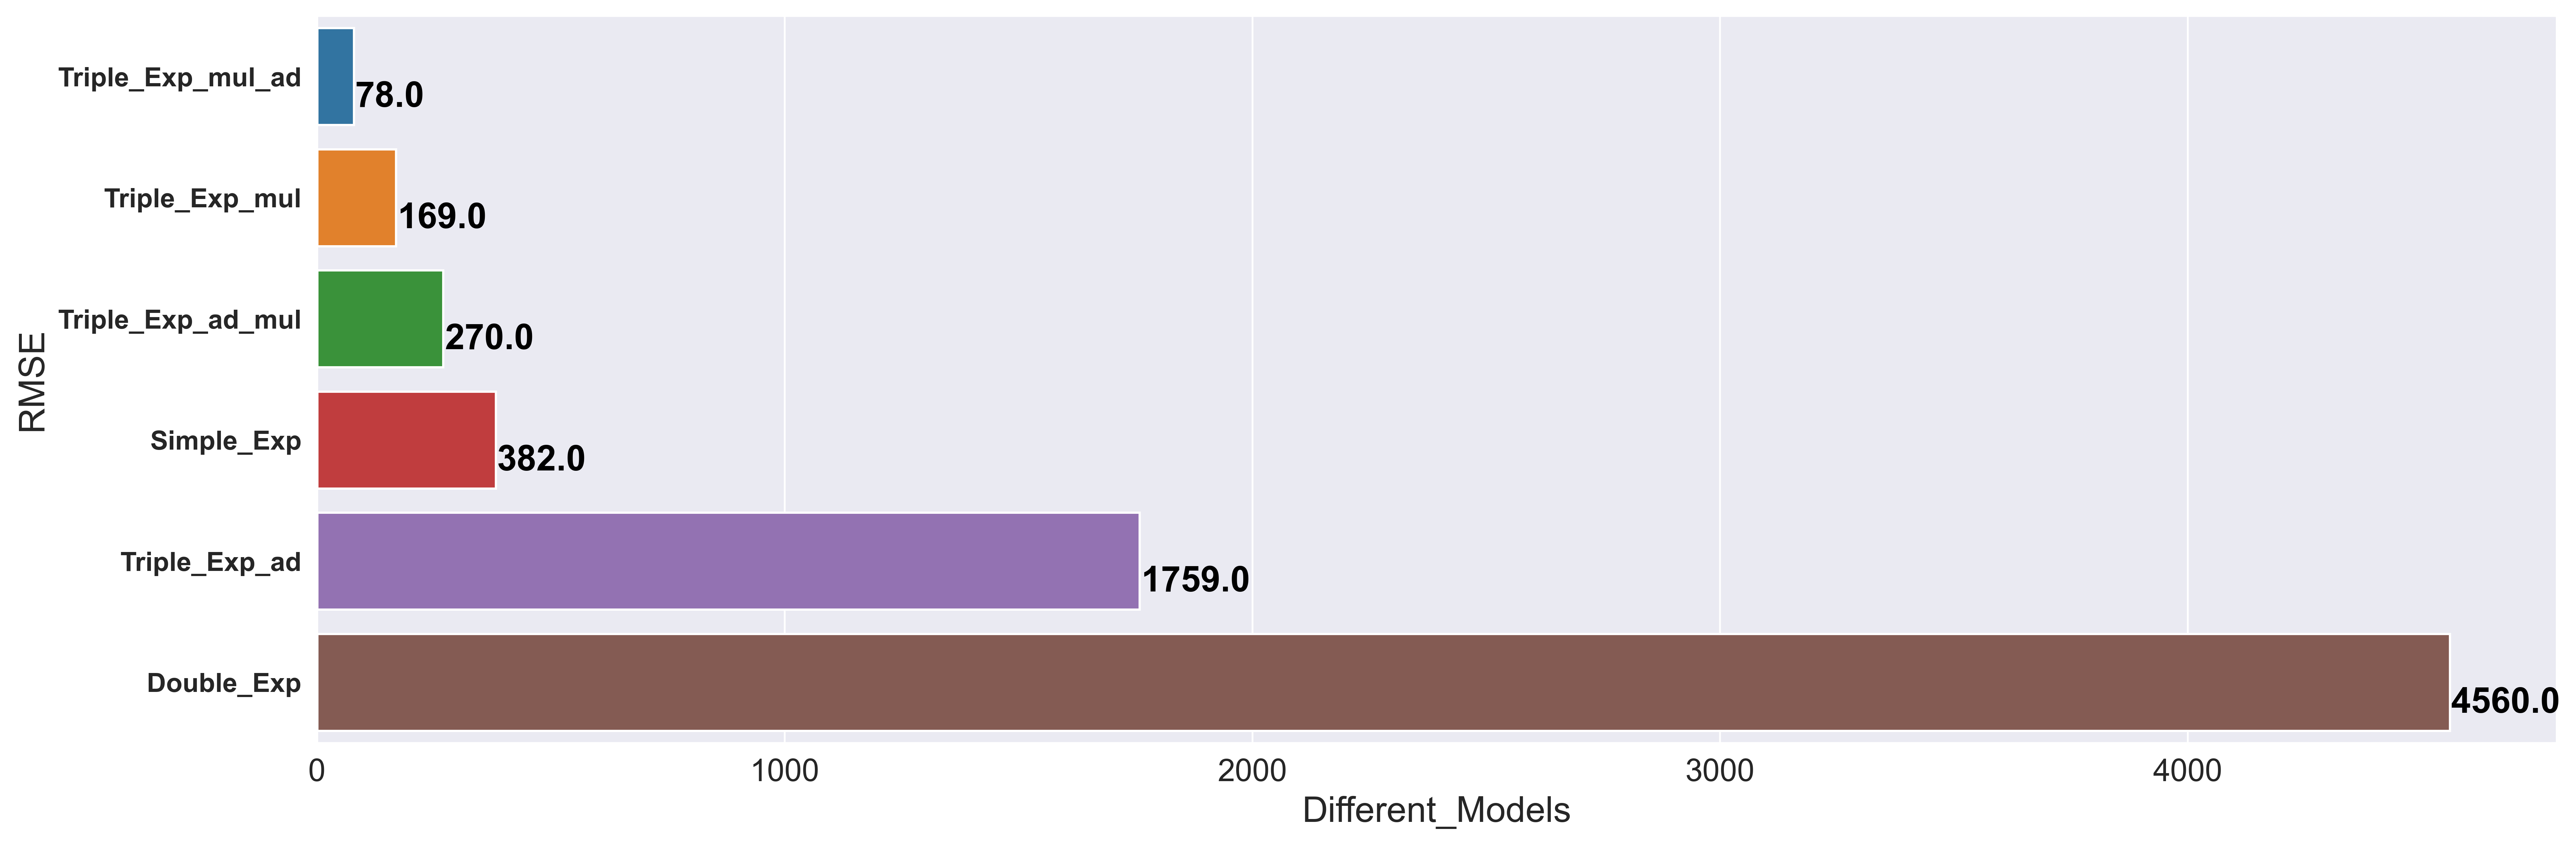

In [221]:
#Visualizing Models Performance
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

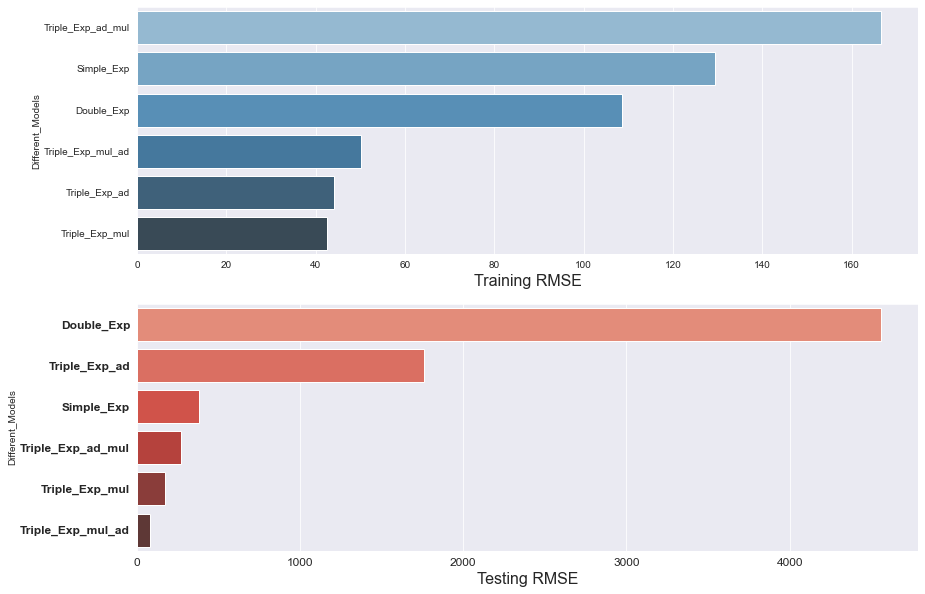

In [222]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

In [223]:
#Test of Stationarity
#As we have quarterly data the window size for moving average is equal to 4
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

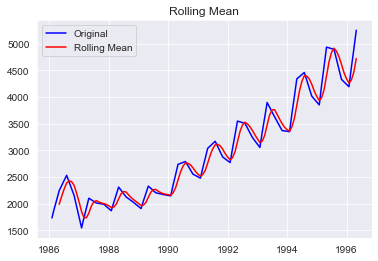

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [224]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [225]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


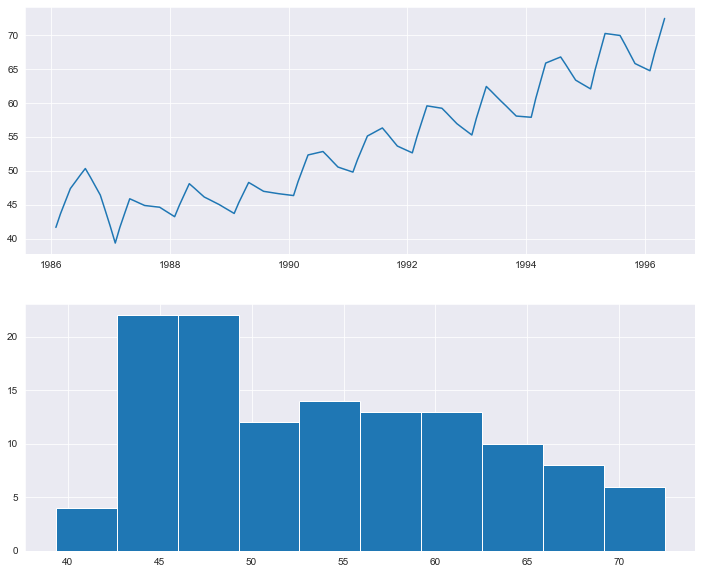

In [226]:
#Feature Scaling (Transformations)
#Square Root Transform
square_root= pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

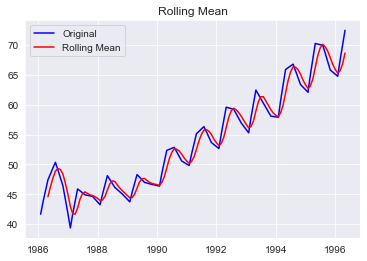

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [227]:
test_stationarity(square_root)

In [228]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


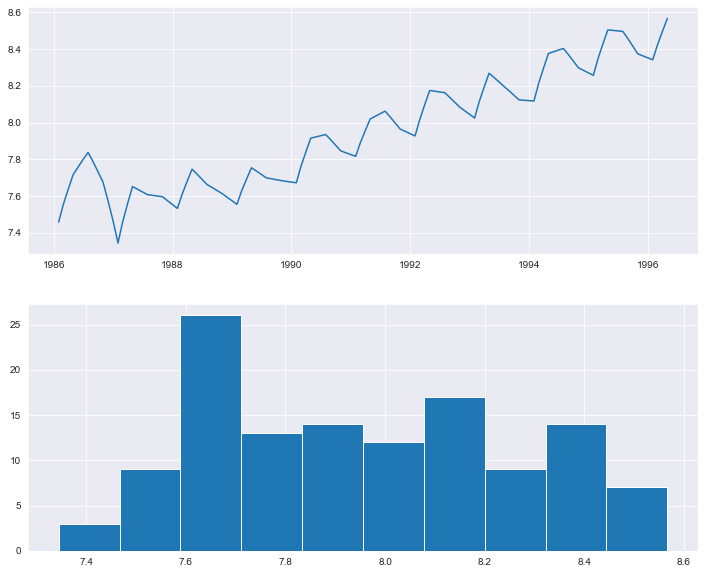

In [229]:
#Log Transform
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

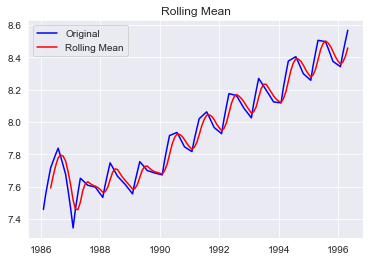

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [230]:
test_stationarity(log)

In [231]:
adf_test(log.Sales)

Fail to reject the null hypothesis
Data is non-stationary


,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


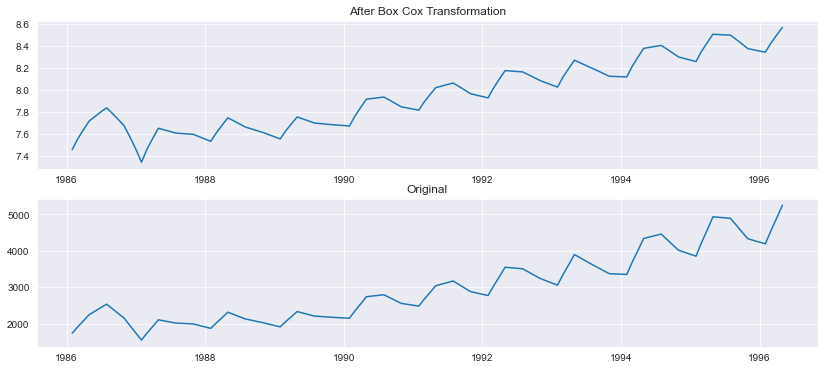

In [232]:
#Converting Non-Stationary Time Series into Stationary
#Box Cox Transformation
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

In [233]:
#Observation
We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance 
is almost similar.
But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing
for making the mean constant.

SyntaxError: invalid syntax (1412875942.py, line 2)

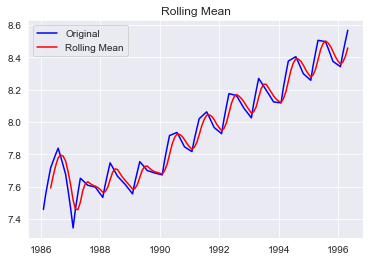

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [234]:
test_stationarity(data_boxcox)

In [235]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


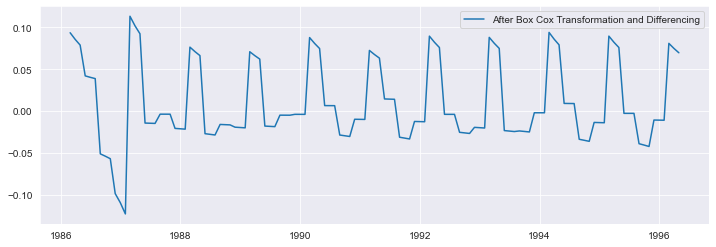

In [236]:
#Differencing of the Box-Cox Transformation
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

In [237]:
#Observation
We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.
It is a horizontal trend.
The mean became constant. The mean is zero.
Also, the variance is almost constant.
Lets test the Stationarity again.

SyntaxError: invalid syntax (3680541345.py, line 2)

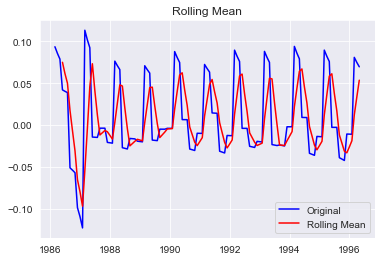

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [238]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [239]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


In [240]:
#ARIMA Hyperparameter Tuning
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [241]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [243]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models( train.values,p_values, d_values, q_values)

LU decomposition error.
Best ARIMA(4, 1, 4) RMSE=83.860


In [88]:
#Building The Time Series Forecasting with Optimal Value using ARIMA
#Automatically performs the Differencing if the series has trend.

#Hence, no need to manually perform the differencing.

train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

In [89]:
#Inverse transformation of the Box-Cox Differencing
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].add(data_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast'])

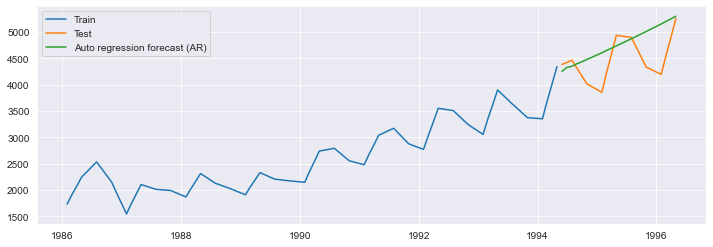

In [90]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['ar_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [ ]:
#Observation
We can see that we have done moderately well.
No Seasonality captured. Only Trend has been captured

In [91]:
#Model Evaluation
#RMSE (Root Mean Squared Error)
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['ar_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

473.6

In [92]:
#MAPE (Mean Absolute Percent Error)
mape_arima = round(np.mean(np.abs((test_data - y_hat_ar['ar_forecast'][test_data.index.min():])/test_data)*100),2)
mape_arima

1994-05-31 00:00:00   NaN
1994-06-30 00:00:00   NaN
1994-07-31 00:00:00   NaN
1994-08-31 00:00:00   NaN
1994-09-30 00:00:00   NaN
1994-10-31 00:00:00   NaN
1994-11-30 00:00:00   NaN
1994-12-31 00:00:00   NaN
1995-01-31 00:00:00   NaN
1995-02-28 00:00:00   NaN
1995-03-31 00:00:00   NaN
1995-04-30 00:00:00   NaN
1995-05-31 00:00:00   NaN
1995-06-30 00:00:00   NaN
1995-07-31 00:00:00   NaN
1995-08-31 00:00:00   NaN
1995-09-30 00:00:00   NaN
1995-10-31 00:00:00   NaN
1995-11-30 00:00:00   NaN
1995-12-31 00:00:00   NaN
1996-01-31 00:00:00   NaN
1996-02-29 00:00:00   NaN
1996-03-31 00:00:00   NaN
1996-04-30 00:00:00   NaN
Sales                 NaN
dtype: float64

In [ ]:
#Observation
We can see that AR model has done reasonably good job but not better than Holt's method.
We souldn't compare it with Holt's method. Because Holt's method captures seasonality

In [93]:
#Analysing the Residuals
#The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

0.00018295402881212376

In [94]:
#Residuals must be stationary
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


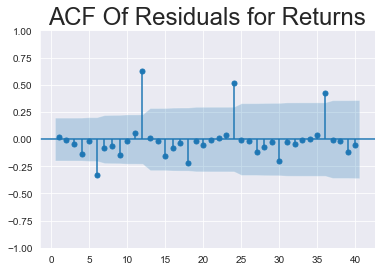

In [95]:
#No autocorrelation between residuals
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

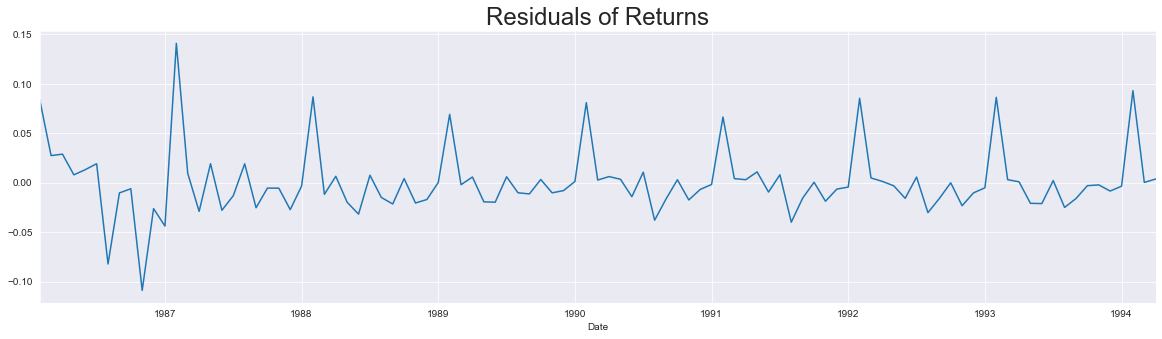

In [96]:
#Residuals must be random
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [97]:
#ARIMA on the Original Data without UpSampling
# separate out a validation dataset
size = int(np.round(len(df1)*0.70,))

cocacola_train = df1.Sales[:size]
cocacola_validation = df1.Sales[size:]
print('Dataset %d, Validation %d' % (len(cocacola_train), len(cocacola_validation)))
cocacola_train.to_csv('cocacola_train.csv', header=False)
cocacola_validation.to_csv('cocacola_validation.csv', header=False)

Dataset 29, Validation 13


In [98]:
# separate out a validation dataset
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))
train_data.to_csv('cocacola_train.csv', header=False)
test_data.to_csv('cocacola_validation.csv', header=False)

Dataset 100, Validation 24


In [99]:
# load dataset
train = pd.read_csv('cocacola_train.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train = train.astype('int64')
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(train.values, p_values, d_values, q_values)

LU decomposition error.
Best ARIMA(4, 1, 4) RMSE=83.860


In [244]:
# separate out a validation dataset
size = int(np.round(len(cocacola_train)*0.70,))

train_data = cocacola_train[:size]
test_data = cocacola_train[size:]
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))

Dataset 20, Validation 9


In [245]:
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))

Dataset 20, Validation 9


In [246]:
model = ARIMA(train_data,order=(4, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   20
Model:                 ARIMA(4, 1, 4)   Log Likelihood         -6768116821.074
Date:                Thu, 11 May 2023   AIC                    13536233660.148
Time:                        11:46:53   BIC                    13536233668.648
Sample:                    01-01-1986   HQIC                   13536233661.587
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       2.191e-07   3.67e-10    596.712      0.000    2.18e-07     2.2e-07
ar.L2      -3.102e-07   3.05e-10  -1015.832      0.000   -3.11e-07    -3.1e-07
ar.L3      -7.757e-08   4.02e-10   -193.077      0.000   -7.84e-08   -7.68e-08
ar.L4       1.662e-07   3.09e-10    538.847      0.000    1.66e-07    1.67e-07
ma.L1       2.191e-07   3.67e-10    596.693      0.000    2.18e-07     2.2e-07
ma.L2      -3.102e-07   3.05e-10  -1015.852      0.000   -3.11e-07    -3.1e-07
ma.L3      -7.757e-08   4.02e-10   -193.080      0.000   -7.84e-08   -7.68e-08
ma.L4       1.662e-07   3.09e-10    538.839      0.000    1.66e-07    1.67e-07
sigma2         0.0002    1.4e-13   1.08e+09      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.43   Prob(JB):                         0.75
Heteroskedasticity (H):               0.36   Skew:                             0.20
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.53e+17. Standard errors may be unstable.
"""

In [247]:
#Use model to predict
# Obtain predicted values
start=len(train_data)
end=len(cocacola_train)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(4,1,4) Predictions')

In [248]:
# Compare predictions to expected values
for i in range(len(test_data)):
    print(f"predicted={predictions[i]:<.10}, expected={test_data[i]}")

predicted=2556.009757, expected=2480.9739990234375
predicted=2556.010092, expected=3039.522994995117
predicted=2556.010147, expected=3172.115997314453
predicted=2556.010068, expected=2879.0009994506836
predicted=2556.010068, expected=2772.0
predicted=2556.010068, expected=3550.0
predicted=2556.010068, expected=3508.0
predicted=2556.010068, expected=3243.859992980957
predicted=2556.010068, expected=3056.0


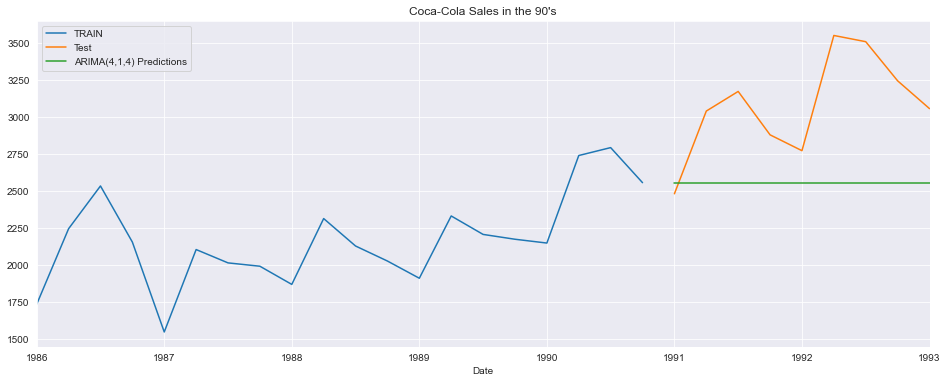

In [249]:
# Plot predictions against known values
title = "Coca-Cola Sales in the 90's"
ylabel='Sales'
xlabel='' 

train_data.plot(legend=True,label='TRAIN' ,figsize=(16,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(16,6),title=title)
predictions.plot(legend=True)
plt.show()

In [253]:
#Evaluate the Model
from statsmodels.tools.eval_measures import rmse
rmse_arima = rmse(test_data, predictions)
rmse_arima.round(2)

613.5

In [254]:
#Seasonal Auto Regressive Integrated Moving Average (SARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [255]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [256]:
#Inverse Transformation of the Differencing Box-Cox Transformation
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [119]:
#Analysing the Residuals
#The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

0.03701866351654992

In [120]:
#Residuals must be stationary
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


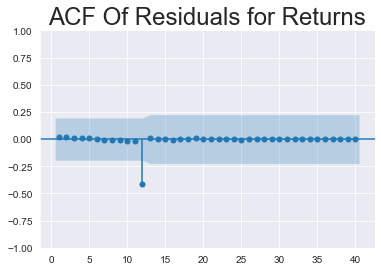

In [121]:
#No autocorrelation between residuals
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

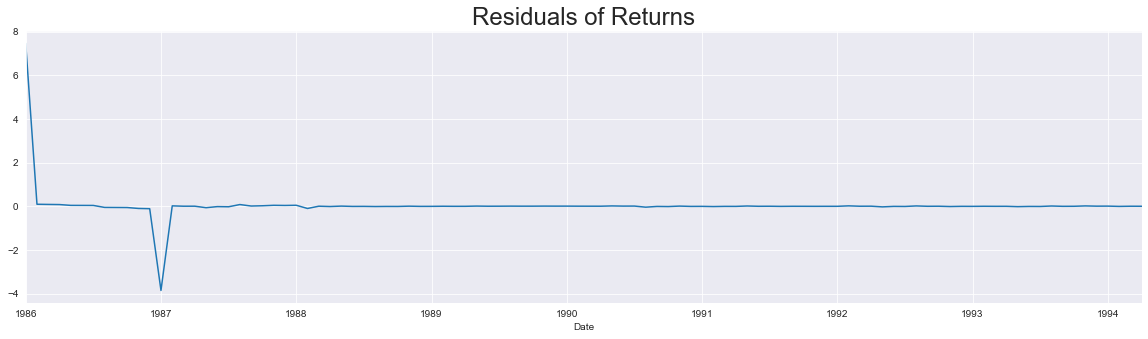

In [122]:
#Residuals must be random
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [125]:
#Data Pre-processing for Model Driven Techniques
#Creating Dummy Variables of the Categorical Feature Month of Date Time feature
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


<AxesSubplot:xlabel='month', ylabel='year'>

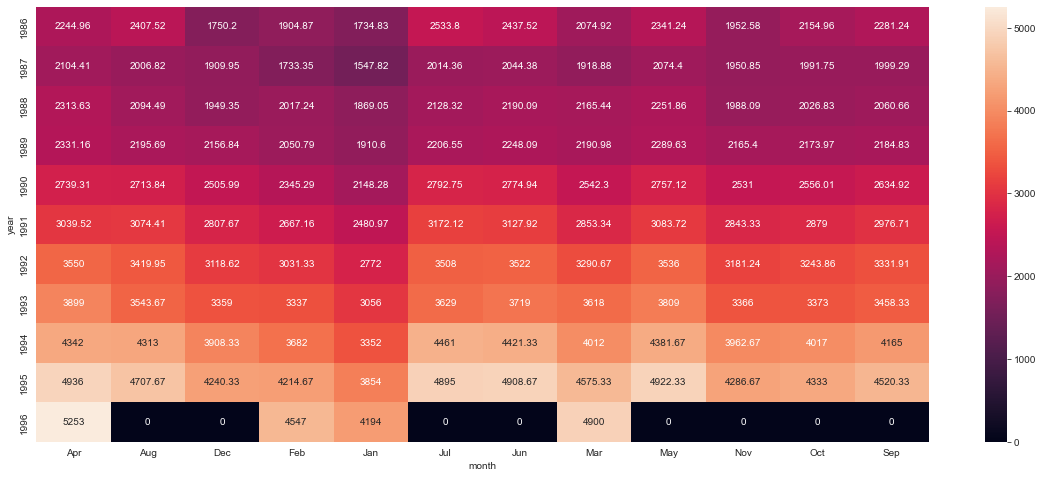

In [126]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

In [127]:
#Splitting data into Train and Test
#70% of data into Train data and rest for Test Data
size = 100
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [128]:
train_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1993-12-31,3359.000000,96,9216,Dec,1993,0,0,0,0,0,0,0,0,0,0,0,1,8.119399
96,1994-01-31,3352.000000,97,9409,Jan,1994,1,0,0,0,0,0,0,0,0,0,0,0,8.117312
97,1994-02-28,3682.000000,98,9604,Feb,1994,0,1,0,0,0,0,0,0,0,0,0,0,8.211211
98,1994-03-31,4012.000000,99,9801,Mar,1994,0,0,1,0,0,0,0,0,0,0,0,0,8.297045


In [129]:
test_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
100,1994-05-31,4381.666667,101,10201,May,1994,0,0,0,0,1,0,0,0,0,0,0,0,8.385184
101,1994-06-30,4421.333333,102,10404,Jun,1994,0,0,0,0,0,1,0,0,0,0,0,0,8.394197
102,1994-07-31,4461.000000,103,10609,Jul,1994,0,0,0,0,0,0,1,0,0,0,0,0,8.403128
103,1994-08-31,4313.000000,104,10816,Aug,1994,0,0,0,0,0,0,0,1,0,0,0,0,8.369389
104,1994-09-30,4165.000000,105,11025,Sep,1994,0,0,0,0,0,0,0,0,1,0,0,0,8.334472
105,1994-10-31,4017.000000,106,11236,Oct,1994,0,0,0,0,0,0,0,0,0,1,0,0,8.298291
106,1994-11-30,3962.666667,107,11449,Nov,1994,0,0,0,0,0,0,0,0,0,0,1,0,8.284672
107,1994-12-31,3908.333333,108,11664,Dec,1994,0,0,0,0,0,0,0,0,0,0,0,1,8.270866
108,1995-01-31,3854.000000,109,11881,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,8.256867
109,1995-02-28,4214.666667,110,12100,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,8.346326


In [130]:
#Building Ordinary Square Model (Linear Model)
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.874086366894

In [131]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     397.1
Date:                Thu, 11 May 2023   Prob (F-statistic):           3.03e-36
Time:                        11:29:43   Log-Likelihood:                -705.92
No. Observations:                 100   AIC:                             1416.
Df Residuals:                      98   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1642.3384     57.309     28.658      0.000    1528.611    1756.065
t             19.6334      0.985     19.928      0.000      17.678      21.589
==============================================================================
Omnibus:                        7.535   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.789
Skew:                           0.683   Prob(JB):                       0.0204
Kurtosis:                       2.929   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
#Exponential

Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.3268025099024

In [133]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     406.5
Date:                Thu, 11 May 2023   Prob (F-statistic):           1.20e-36
Time:                        11:30:03   Log-Likelihood:                 84.607
No. Observations:                 100   AIC:                            -165.2
Df Residuals:                      98   BIC:                            -160.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4782      0.021    353.829      0.000       7.436       7.520
t              0.0073      0.000     20.162      0.000       0.007       0.008
==============================================================================
Omnibus:                        6.147   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.627
Skew:                           0.561   Prob(JB):                       0.0600
Kurtosis:                       3.301   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
#Quadratic 
Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

371.2941834498657

In [135]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     325.2
Date:                Thu, 11 May 2023   Prob (F-statistic):           9.85e-44
Time:                        11:30:26   Log-Likelihood:                -684.82
No. Observations:                 100   AIC:                             1376.
Df Residuals:                      97   BIC:                             1383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2022.9480     70.858     28.549      0.000    1882.314    2163.582
t             -2.7554      3.238     -0.851      0.397      -9.183       3.672
t_squared      0.2217      0.031      7.136      0.000       0.160       0.283
==============================================================================
Omnibus:                        3.492   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.371
Skew:                           0.193   Prob(JB):                        0.306
Kurtosis:                       2.352   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
#Additive seasonality 

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483788

In [137]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6210
Date:                Thu, 11 May 2023   Prob (F-statistic):              0.806
Time:                        11:30:48   Log-Likelihood:                -783.17
No. Observations:                 100   AIC:                             1590.
Df Residuals:                      88   BIC:                             1622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2431.1678     60.077     40.467      0.000    2311.777    2550.559
Jan         -112.1065    208.114     -0.539      0.591    -525.689     301.476
Feb           98.7249    208.114      0.474      0.636    -314.858     512.308
Mar          309.5564    208.114      1.487      0.140    -104.026     723.139
Apr          520.3878    208.114      2.500      0.014     106.805     933.971
May          336.7034    219.714      1.532      0.129     -99.932     773.339
Jun          326.8245    219.714      1.488      0.140    -109.811     763.460
Jul          316.9457    219.714      1.443      0.153    -119.690     753.581
Aug          250.8819    219.714      1.142      0.257    -185.753     687.517
Sep          184.8182    219.714      0.841      0.403    -251.817     621.453
Oct          118.7544    219.714      0.540      0.590    -317.881     555.390
Nov           66.1439    219.714      0.301      0.764    -370.491     502.779
Dec           13.5333    219.714      0.062      0.951    -423.102     450.168
==============================================================================
Omnibus:                       30.612   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.038
Skew:                           0.459   Prob(JB):                       0.0109
Kurtosis:                       1.848   Cond. No.                     1.24e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.01e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [138]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.80498810374885

In [139]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     138.2
Date:                Thu, 11 May 2023   Prob (F-statistic):           8.95e-52
Time:                        11:31:11   Log-Likelihood:                -632.59
No. Observations:                 100   AIC:                             1293.
Df Residuals:                      86   BIC:                             1330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1865.7939     41.512     44.946      0.000    1783.271    1948.316
t             -2.9439      2.056     -1.432      0.156      -7.032       1.144
t_squared      0.2253      0.020     11.418      0.000       0.186       0.265
Jan         -159.7690     46.717     -3.420      0.001    -252.640     -66.898
Feb           31.7000     46.733      0.678      0.499     -61.202     124.602
Mar          222.7184     46.754      4.764      0.000     129.774     315.663
Apr          413.2862     46.781      8.834      0.000     320.288     506.284
May          372.3785     49.451      7.530      0.000     274.074     470.683
Jun          344.0384     49.465      6.955      0.000     245.706     442.371
Jul          315.2478     49.481      6.371      0.000     216.884     413.612
Aug          229.8216     49.499      4.643      0.000     131.421     328.222
Sep          143.9448     49.519      2.907      0.005      45.505     242.385
Oct           57.6174     49.541      1.163      0.248     -40.867     156.102
Nov          -15.7075     49.565     -0.317      0.752    -114.240      82.825
Dec          -89.4829     49.592     -1.804      0.075    -188.068       9.102
==============================================================================
Omnibus:                        0.473   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.611
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.617   Cond. No.                     8.83e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.63e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [140]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1904.7944171920333

In [141]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Thu, 11 May 2023   Prob (F-statistic):              0.767
Time:                        11:31:33   Log-Likelihood:                 6.6723
No. Observations:                 100   AIC:                             10.66
Df Residuals:                      88   BIC:                             41.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2447      0.022    324.766      0.000       7.200       7.289
Jan            0.4719      0.077      6.107      0.000       0.318       0.626
Feb            0.5592      0.077      7.236      0.000       0.406       0.713
Mar            0.6393      0.077      8.273      0.000       0.486       0.793
Apr            0.7134      0.077      9.232      0.000       0.560       0.867
May            0.6582      0.082      8.068      0.000       0.496       0.820
Jun            0.6547      0.082      8.025      0.000       0.493       0.817
Jul            0.6508      0.082      7.977      0.000       0.489       0.813
Aug            0.6277      0.082      7.694      0.000       0.466       0.790
Sep            0.6038      0.082      7.401      0.000       0.442       0.766
Oct            0.5791      0.082      7.098      0.000       0.417       0.741
Nov            0.5558      0.082      6.812      0.000       0.394       0.718
Dec            0.5309      0.082      6.508      0.000       0.369       0.693
==============================================================================
Omnibus:                       74.329   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.756
Skew:                           0.261   Prob(JB):                       0.0125
Kurtosis:                       1.648   Cond. No.                     1.24e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.01e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [142]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

396.41978173824793

In [143]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     61.10
Date:                Thu, 11 May 2023   Prob (F-statistic):           4.29e-37
Time:                        11:31:53   Log-Likelihood:                 114.86
No. Observations:                 100   AIC:                            -203.7
Df Residuals:                      87   BIC:                            -169.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9000      0.015    450.015      0.000       6.870       6.931
t              0.0074      0.000     25.888      0.000       0.007       0.008
Jan            0.4543      0.026     17.240      0.000       0.402       0.507
Feb            0.5342      0.026     20.263      0.000       0.482       0.587
Mar            0.6069      0.026     23.011      0.000       0.554       0.659
Apr            0.6736      0.026     25.526      0.000       0.621       0.726
May            0.6553      0.028     23.563      0.000       0.600       0.711
Jun            0.6445      0.028     23.171      0.000       0.589       0.700
Jul            0.6332      0.028     22.759      0.000       0.578       0.688
Aug            0.6027      0.028     21.656      0.000       0.547       0.658
Sep            0.5714      0.028     20.523      0.000       0.516       0.627
Oct            0.5392      0.028     19.360      0.000       0.484       0.595
Nov            0.5085      0.028     18.246      0.000       0.453       0.564
Dec            0.4763      0.028     17.077      0.000       0.421       0.532
==============================================================================
Omnibus:                       14.672   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.352
Skew:                           0.801   Prob(JB):                     0.000171
Kurtosis:                       4.264   Cond. No.                     7.60e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.86e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""